# Indiana Pines

1. Import dependencies

In [ ]:
import random
import torch
import multiprocessing
import numpy as np

import torch.utils.data as data

from lightning import Trainer

from src.util.torch import resolve_torch_device
from src.util.hsi import (
    extract_patches,
    reduce_hsi_dim,
    train_test_band_patch_split,
    preprocess_hsi,
    PreProcessType,
    DimReductionType,
    read_fixed_labels_mask,
    train_test_split_by_mask,
)
from src.data.indian_pines import load_indian_pines
from src.model.hsic import HyperSpectralImageClassifier
from src.visualization.plot import (
    plot_segmentation_comparison,
    plot_masked_segmentation_comparison,
    plot_epoch_generic,
    plot_epoch_generic_comparison,
)
from src.data.dataset_decorator import UnlabeledDatasetDecorator
from src.util.reporting import (
    create_model_name,
    report_run,
    read_report_to_show,
    lightning_metrics,
)
from src.util.list_ext import smooth_moving_average
from src.model.fdssc import FDSSC_f
from src.util.dict_ext import arrange_and_repeat

2. Prepare env

In [2]:
learning_rate = 1e-3
weight_decay = 0
num_epochs = 300

In [3]:
batch_size = 64
patch_size = 9
target_dim = 75

examples_per_class = []

pre_process_type = PreProcessType.STANDARTIZATION
dim_reduction_type = DimReductionType.PCA

In [4]:
random_seed = 42

random.seed(random_seed)
torch.manual_seed(random_seed)
np.random.seed(random_seed)

device = resolve_torch_device()

In [5]:
torch.cuda.empty_cache()

In [6]:
torch.set_float32_matmul_precision("medium")

In [7]:
f"Device is {device}"

'Device is cuda'

3. Load dataset

In [8]:
image, labels = load_indian_pines()

image_h, image_w, image_c = image.shape

In [9]:
_, image = preprocess_hsi(image, pre_process_type)

In [10]:
_, target_dim, image = reduce_hsi_dim(
    image, target_dim, dim_reduction_type, device, random_seed
)

In [11]:
x, y = extract_patches(image, labels, patch_size=patch_size)

In [12]:
num_classes = len(np.unique(y))

f"Number of classes {num_classes}"

'Number of classes 17'

In [13]:
examples_per_class = arrange_and_repeat(num_classes, 20)

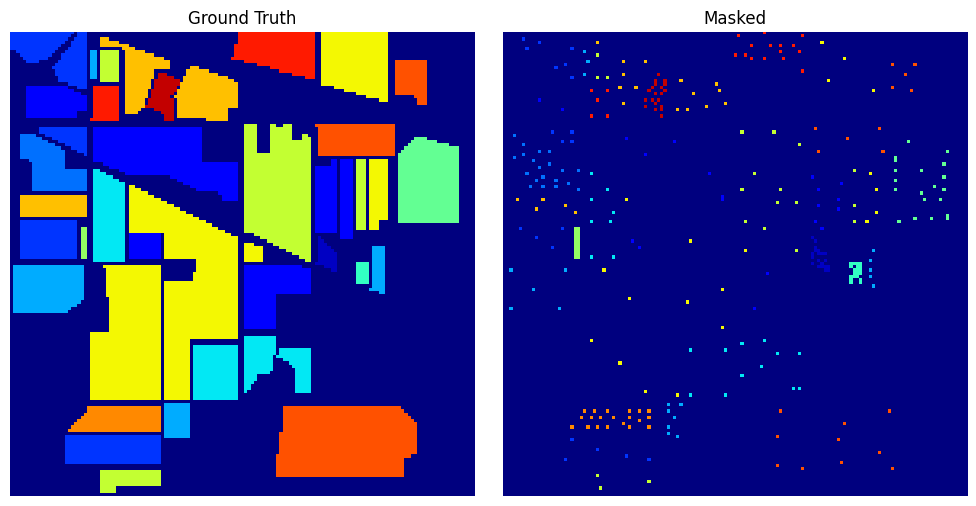

In [14]:
mask = read_fixed_labels_mask("indian-pines-v1.npy")

x_train, y_train, x_test, y_test = train_test_split_by_mask(x, y, mask)

_ = plot_masked_segmentation_comparison(y.reshape(image_h, image_w), mask)

In [15]:
x_tensor = torch.tensor(x, dtype=torch.float32).permute(0, 3, 1, 2) 
y_tensor = torch.tensor(y, dtype=torch.long)
x_train_tensor = torch.tensor(x_train, dtype=torch.float32).permute(0, 3, 1, 2)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
x_test_tensor = torch.tensor(x_test, dtype=torch.float32).permute(0, 3, 1, 2)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

In [16]:
cpu_count = multiprocessing.cpu_count()

f"Setting num_workers to {cpu_count}"

'Setting num_workers to 24'

In [17]:
train_dataset = data.TensorDataset(x_train_tensor, y_train_tensor)
test_dataset = data.TensorDataset(x_test_tensor, y_test_tensor)
full_dataset = data.TensorDataset(x_tensor, y_tensor)

train_loader = data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=cpu_count,
    persistent_workers=True,
)
test_loader = data.DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=cpu_count,
    persistent_workers=True,
)
full_loader = data.DataLoader(
    full_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=cpu_count,
    persistent_workers=True,
)
predict_loader = data.DataLoader(
    UnlabeledDatasetDecorator(full_dataset),
    batch_size=batch_size,
    num_workers=cpu_count,
    persistent_workers=True,
)

In [18]:
f"Training samples: {len(train_dataset)}, Testing samples: {len(test_dataset)}"

'Training samples: 340, Testing samples: 20685'

4. Train model

In [19]:
model = HyperSpectralImageClassifier(
    FDSSC_f(
        band=target_dim,
        classes=num_classes,
    ),
    num_classes,
    lr=learning_rate,
    weight_decay=weight_decay,
    # scheduler=lambda opt: torch.optim.lr_scheduler.ReduceLROnPlateau(
    #     opt, factor=0.5, patience=10
    # ),
)

trainer = Trainer(accelerator="auto", max_epochs=num_epochs)

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


FDSSC_f


/home/melal/Workspace/spatial-regulated-self-training/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default


In [20]:
trainer.fit(
    model,
    train_loader, 
    # test_loader,
)

/home/melal/Workspace/spatial-regulated-self-training/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                 | Params | Mode 
------------------------------------------------------------------
0 | net              | FDSSC_f              | 486 K  | train
1 | loss_fun         | CrossEntropyLoss     | 0      | train
2 | f1               | MulticlassF1Score    | 0      | train
3 | overall_accuracy | MulticlassAccuracy   | 0      | train
4 | average_accuracy | MulticlassAccuracy   | 0      | train
5 | kappa            | MulticlassCohenKappa | 0      | train
------------------------------------------------------------------
486 K     Trainable params
0         Non-trainable params
486 K     Total params
1.946     Total estimated model params size (MB)
46        Modules in train mode
0      

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=300` reached.


In [21]:
# smothed_train = smooth_moving_average([it.loss.cpu() for it in model.train_metrics], 20)
# smothed_eval = smooth_moving_average([it.loss.cpu() for it in model.val_metrics], 20)

# plot_epoch_generic_comparison(smothed_train, smothed_eval)

In [22]:
# smooth_f1 = smooth_moving_average([it.f1.cpu() for it in model.val_metrics], 20)

# plot_epoch_generic(smooth_f1, desc="F1")

In [23]:
validation_result = trainer.validate(model, full_loader)

validation_result

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
  val_average_accuracy      0.6830915808677673
         val_f1             0.7083187103271484
        val_kappa           0.5280746221542358
        val_loss            1.6726055145263672
  val_overall_accuracy      0.5093495845794678
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'val_loss': 1.6726055145263672,
  'val_f1': 0.7083187103271484,
  'val_overall_accuracy': 0.5093495845794678,
  'val_average_accuracy': 0.6830915808677673,
  'val_kappa': 0.5280746221542358}]

2. Display prediction

In [24]:
y_pred = trainer.predict(model, predict_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

In [25]:
y_pred = torch.cat(y_pred, dim=0)
y_pred = torch.argmax(y_pred, dim=1)
y_pred = y_pred.reshape(image_h, image_w)

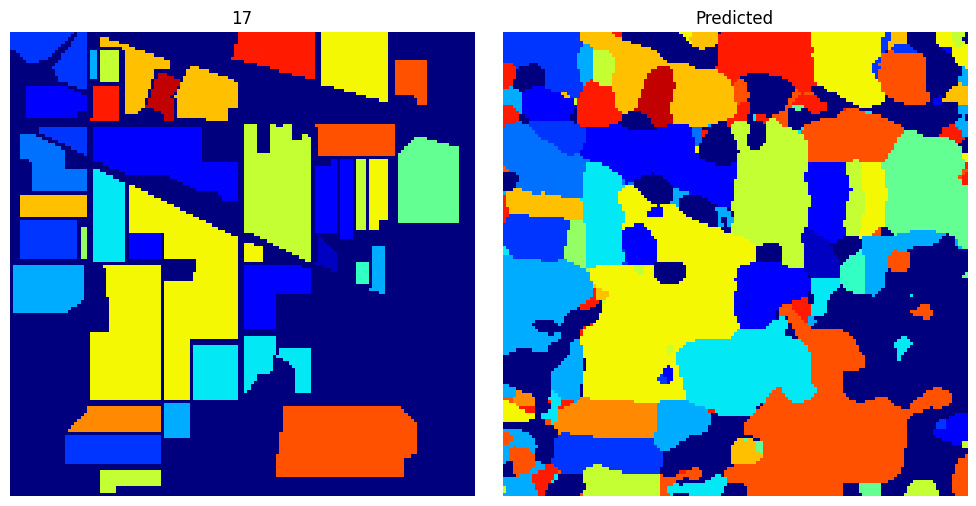

In [26]:
plot_segmentation_comparison(y.reshape(image_h, image_w), y_pred.numpy(), num_classes)

6. Write report

In [27]:
model_name = create_model_name("indian_pines_", examples_per_class)
model_category = "fdssc"

run_params = {
    "num_epochs": num_epochs,
    "batch_size": batch_size,
    "patch_size": patch_size,
    "target_dim": target_dim,
    "pre_process_type": str(pre_process_type),
    "dim_reduction_type": str(dim_reduction_type),
}

report_run(
    model_name=model_name,
    model_category=model_category,
    run_desc="Fixed mask, larger lr",
    run_params=run_params | model.get_params(),
    run_metrics=lightning_metrics(validation_result),
)

PosixPath('/home/melal/Workspace/spatial-regulated-self-training/reports/runs/indian_pines__0-20_1-20_2-20_3-20_4-20_5-20_6-20_7-20_8-20_9-20_10-20_11-20_12-20_13-20_14-20_15-20_16-20.csv')

In [28]:
read_report_to_show(model_name, sort_by_metric="f1")

,timestamp,model_category,run_desc,params,loss,f1,OA,AA,kappa
64,2025-05-31T12:52:12.314211+00:00,lenet_multiview,"New fixed mask, 2 epochs, new unlabled shrinking","{""num_epochs"": 15, ""batch_size"": 32, ""patch_si...",NaN,0.790402,0.878032,0.787206,0.703928
67,2025-05-31T18:17:32.920559+00:00,lenet_multiview,"New fixed mask, 2 epoch, new unlabled shrinking","{""num_epochs"": 15, ""batch_size"": 32, ""patch_si...",NaN,0.790402,0.878032,0.787206,0.703928
62,2025-05-30T20:38:12.198151+00:00,lenet_multiview,"New fixed mask, less epochs","{""num_epochs"": 15, ""batch_size"": 32, ""patch_si...",NaN,0.761022,0.824273,0.768847,0.657544
72,2025-06-01T11:04:28.706267+00:00,lenet_multiview,"Self learning, 8 epochs, new unlabled shrinkin...","{""num_epochs"": 30, ""batch_size"": 32, ""patch_si...",NaN,0.760632,0.838244,0.765612,0.657339
63,2025-05-31T12:39:48.464309+00:00,lenet_multiview,"New fixed mask, more epochs, new unlabled shri...","{""num_epochs"": 15, ""batch_size"": 32, ""patch_si...",NaN,0.758548,0.828754,0.762759,0.654074
...,...,...,...,...,...,...,...,...,...
22,2025-05-25T14:39:13.847478+00:00,specteal_former_co_training,Default run,"{""hidden_dim"": 32, ""num_layers"": 5, ""num_heads...",2.814270,0.179225,0.430531,0.176266,0.130307
10,2025-05-25T09:30:05.188620+00:00,vit,Add weight decay,"{""hidden_dim"": 64, ""num_layers"": 5, ""num_heads...",5.515652,0.177391,0.052552,0.143306,0.060421
73,2025-06-01T20:02:30.458685+00:00,vit,"Fixed mask, add weight decay, increase dropout...","{""num_epochs"": 300, ""batch_size"": 64, ""patch_s...",2.716200,0.168771,0.048153,0.131034,0.049644
24,2025-05-25T16:13:53.131416+00:00,lenet_co_training,"Less epochs, no scheduling","{""learning_rate"": 0.001, ""num_epochs"": 30, ""ba...",2.827521,0.147750,0.677064,0.252176,0.225479


In [29]:
read_report_to_show(model_name, sort_by_metric="f1", model_category=model_category)

,timestamp,run_desc,params,loss,f1,OA,AA,kappa
76,2025-06-01T20:21:21.054393+00:00,"Fixed mask, larger lr","{""num_epochs"": 300, ""batch_size"": 64, ""patch_s...",1.672606,0.708319,0.509350,0.683092,0.528075
37,2025-05-26T10:53:25.065429+00:00,Default run,"{""learning_rate"": 0.0001, ""weight_decay"": 0, ""...",1.341803,0.670137,0.478700,0.650464,0.480878
48,2025-05-27T14:30:47.867891+00:00,"Scheduler for loss, larger lr","{""num_epochs"": 300, ""batch_size"": 64, ""patch_s...",1.641746,0.656210,0.463644,0.636766,0.471007
49,2025-05-27T14:39:29.850243+00:00,Larger lr,"{""num_epochs"": 300, ""batch_size"": 64, ""patch_s...",2.278236,0.645094,0.445661,0.624590,0.461505
46,2025-05-27T14:27:12.497711+00:00,Scheduler for val_loss,"{""num_epochs"": 300, ""batch_size"": 64, ""patch_s...",1.391315,0.638199,0.432184,0.617503,0.453314
47,2025-05-27T14:29:28.344003+00:00,Scheduler for loss,"{""num_epochs"": 300, ""batch_size"": 64, ""patch_s...",1.406228,0.632592,0.426241,0.612509,0.448813
